# Telling A Story Using Data Project

In this project, I will investigate data on Restaurants in LA, in order to understand the market's current condition and make recommendations for a robot-run cafe partners that wants to opean a venue in LA. 
In order to do that, i will do the following :

1. Explore the data
2. Investigate the proportions of the various types of establishments.
3. Investigate the proportions of chain and nonchain establishments.
4. Determine What characterizes chains in terms of venue type and number of seats.
5. Determine the average number of seats for each type of restaurant. 
6. Plot a graph of the top ten streets by number of restaurants.
7. Find the number of streets that only have one restaurant.
8. For streets with a lot of restaurants, I will look for trends in terms of average seats. 
9. conclusion


In [33]:
# Loading all the libraries i will use:
!pip install usaddress
import usaddress
import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
import math 
from functools import reduce
from scipy import stats as st
import warnings
warnings.filterwarnings("ignore")
import plotly.express as px

import plotly.graph_objects as go

import plotly.offline

plotly.offline.init_notebook_mode(connected=True)
import requests 
import io
import nltk, re
import string
from collections import Counter
from string import punctuation


In [34]:
# Downloading the csv file from my GitHub account

url = "https://raw.githubusercontent.com/yoav-karsenty/Telling-a-story-using-data-Presentation-/main/rest_data_us%20(1).csv"
download = requests.get(url).content

# Reading the downloaded content and turning it into a pandas dataframe

rest = pd.read_csv(io.StringIO(download.decode('utf-8')))

#Exploring the data 


rest.head()

,id,object_name,address,chain,object_type,number
0,11786,HABITAT COFFEE SHOP,3708 N EAGLE ROCK BLVD,False,Cafe,26
1,11787,REILLY'S,100 WORLD WAY # 120,False,Restaurant,9
2,11788,STREET CHURROS,6801 HOLLYWOOD BLVD # 253,False,Fast Food,20
3,11789,TRINITI ECHO PARK,1814 W SUNSET BLVD,False,Restaurant,22
4,11790,POLLEN,2100 ECHO PARK AVE,False,Restaurant,20


In [35]:
rest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9651 entries, 0 to 9650
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           9651 non-null   int64 
 1   object_name  9651 non-null   object
 2   address      9651 non-null   object
 3   chain        9648 non-null   object
 4   object_type  9651 non-null   object
 5   number       9651 non-null   int64 
dtypes: int64(2), object(4)
memory usage: 452.5+ KB


In [36]:
rest[rest.duplicated() == True]

,id,object_name,address,chain,object_type,number


No missing values or duplicates, we are good to go

## Investigate the proportions of the various types of establishments.

In [37]:
#Grouping the data by establishment type
type_group = rest.groupby('object_type')['number'].count().reset_index()

type_group.sort_values(by='number', ascending=False)

,object_type,number
5,Restaurant,7255
3,Fast Food,1066
2,Cafe,435
4,Pizza,320
1,Bar,292
0,Bakery,283


In [38]:
#Visualising the data
name_rest = ['Restaurant', 'Fast Food', 'Cafe', 'Pizza', 'Bar','Bakery']
values = [7255, 1066, 435,320,292,283]

fig = go.Figure(data=[go.Pie(labels=name_rest, values=values)])
fig.update_layout(
    title={
        'text': "Establishment Type",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})

fig.show() 


We can see that Restaurants are the most common establishment in LA with 75.2% of the venues
The least common: Cafes with 4.51% of the venues


##  Investigate the proportions of chain and nonchain establishments.


In [39]:
#Grouping by chain and nochain 
chain_group = rest.groupby('chain')['number'].count().reset_index()

chain_group.sort_values(by='number', ascending=False)

,chain,number
0,False,5972
1,True,3676


In [40]:
#Visualising the data

chain_or = ['No Chain', 'Chain']
values = [5972, 3676]

fig = go.Figure(data=[go.Pie(labels=chain_or, values=values)])

fig.update_layout(
    title={
        'text': "Chain vs NoChain",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})

fig.show() 


We can see that for Chains Vs. single branch venues,
Only 38.1% of the venues are part of a chain

In [41]:
#Grouping establishments tht are a part of a chain by establishmebt type
rest_chain = rest.query('chain == True').groupby(['object_type'])['number'].count().reset_index()
rest_chain = rest_chain.merge(type_group,on = 'object_type')
rest_chain.columns = ['establish_type','is_chain_num','total_num']
rest_chain['chain_perc'] = rest_chain['is_chain_num'] /rest_chain['total_num'] 
rest_chain

,establish_type,is_chain_num,total_num,chain_perc
0,Bakery,283,283,1.000000
1,Bar,77,292,0.263699
2,Cafe,266,435,0.611494
3,Fast Food,605,1066,0.567542
4,Pizza,153,320,0.478125
5,Restaurant,2292,7255,0.315920


Most likely to be a chain: Bakery with 100% of the venues being a part of chain.
Cafes are  61.1% likely to be a part of a chain  
Retsaurantes, wich had the biggest market share, are only 31% likely to ba a part of a chain 


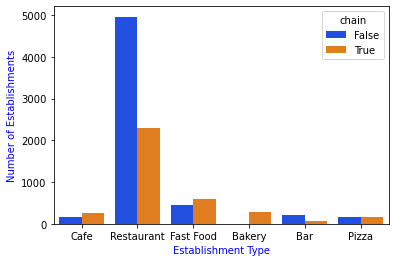

In [42]:
#Visualising the data

ax = sns.countplot(x="object_type", hue="chain", data=rest)

ax.set_ylabel("Number of Establishments", fontsize = 10)
ax.set_xlabel("Establishment Type", fontsize = 10)
ax.xaxis.label.set_color('blue')
ax.yaxis.label.set_color('blue')


sns.set_palette('bright') 


There are 3 Establishment types that are more likely to be a chain:
Café, Fast food and bakery. It is probably cheaper for those types to get ingredients if they are a part of a chain.


## What characterizes chains ?

Next, i want to understand what  characterizes chains: many establishments with a small number of seats or a few establishments with a lot of seats?


In [43]:
#Creating a dataframe with only "is chain" establishments
chain =rest.query('chain == True')
chain.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3676 entries, 8 to 9650
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           3676 non-null   int64 
 1   object_name  3676 non-null   object
 2   address      3676 non-null   object
 3   chain        3676 non-null   object
 4   object_type  3676 non-null   object
 5   number       3676 non-null   int64 
dtypes: int64(2), object(4)
memory usage: 201.0+ KB


In [44]:
#Grouping by chains and calculating the number of venues in each chain and the average seat numner 
avg_seats =chain.groupby(['object_name'])['object_type','number'].agg({'object_type':'count','number' : 'mean'}).reset_index()
avg_seats.columns = ['rest_name','num_of_establish','avg_seat']
avg_seats.sort_values(by ='num_of_establish',ascending = False).head(10)



,rest_name,num_of_establish,avg_seat
2459,THE COFFEE BEAN & TEA LEAF,47,26.723404
2226,SUBWAY,31,16.419355
519,DOMINO'S PIZZA,15,12.333333
2608,WABA GRILL,14,42.857143
1089,KENTUCKY FRIED CHICKEN,14,33.357143
1433,MCDONALD'S,13,96.846154
2544,TRIMANA,13,43.461538
2103,STARBUCKS,12,18.000000
1735,PAPA JOHN'S PIZZA,12,14.500000
2667,YOGURTLAND,12,16.416667


In [45]:
#Visualising the data

scat_seats = px.scatter(avg_seats, x="avg_seat", y="num_of_establish")

scat_seats.update_layout(
    title="What characterizes chains?",
    xaxis_title="Number of establishments",
    yaxis_title="Number of seats",
)
scat_seats.show()
    


most establishments are in the left lower corner, which means:
chains typically have lower number of venues with relatively low number of seats

Next, i want to find the average number of seats for each type of restaurant.

## Average number of seats for each type of restaurant

In [46]:
#Grouping by establishment type and calculating the average seats pper establishment 
avg_rest_seats = rest.groupby('object_type')['number'].mean().reset_index()
avg_rest_seats = avg_rest_seats.sort_values(by = 'number',ascending = False)

In [47]:
#Visualising the data

bar_seats = px.bar(avg_rest_seats, 
             x='object_type', 
             y='number',
            )

bar_seats.update_layout(
    title="Average seats by Restaurant Type",
    xaxis_title="Restaurant Type",
    yaxis_title="Average number of seats",
)

bar_seats.show()

There are no establishment types with more than 50 average seats number 
Cafes have 25 seats average, only Bakerys have less with 21.7


<AxesSubplot:xlabel='object_type', ylabel='number'>

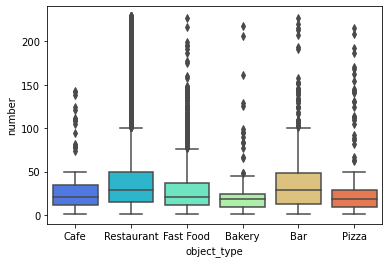

In [48]:
#Getting more info about the distribution of seats by establishment type  using a box plot 
sns.boxplot(x="object_type", y="number", data=rest, palette='rainbow') 


There are a lot of restaurants and fast food venues with a lot of seats, but not as much cafes.


## Top ten streets by number of restaurants

Next, i want to clean the address column from anything but the name of the street, so i could make calculations by streets.

In [49]:
#Creating a function that will help me get clean adress with only streets names 
def clean_address(df):
    raw_address = usaddress.parse(df)
    dict_address = {}
    for i in raw_address:
        dict_address.update({i[1] : i[0]})
        #cheacking for normal cases with street name:
    if 'StreetName' in dict_address.keys():
        clean_address = str(dict_address['StreetName'])
        return clean_address
    else:
        return 'no name'

In [50]:
rest_copy = rest.copy()

In [51]:
#Applying the function on a copy of the data to check if it worked 
rest_copy['clean_street_check'] = rest_copy.address.apply(clean_address)

rest_copy.head()

,id,object_name,address,chain,object_type,number,clean_street_check
0,11786,HABITAT COFFEE SHOP,3708 N EAGLE ROCK BLVD,False,Cafe,26,ROCK
1,11787,REILLY'S,100 WORLD WAY # 120,False,Restaurant,9,WORLD
2,11788,STREET CHURROS,6801 HOLLYWOOD BLVD # 253,False,Fast Food,20,HOLLYWOOD
3,11789,TRINITI ECHO PARK,1814 W SUNSET BLVD,False,Restaurant,22,SUNSET
4,11790,POLLEN,2100 ECHO PARK AVE,False,Restaurant,20,PARK


In [52]:
rest_copy[rest_copy['clean_street_check']=='no name']

,id,object_name,address,chain,object_type,number,clean_street_check
1888,13674,MAGDALENO DEBBIE,OLVERA ST E17,False,Restaurant,15,no name
3719,15505,LAS ANITAS,OLVERA ST 26,False,Restaurant,38,no name
7003,18789,D.K. DONUTS,1033 1/2 LOS ANGELES ST,False,Fast Food,8,no name
7281,19067,CIELITO LINDO,OLVERA ST 23,False,Restaurant,2,no name
7319,19105,JUANITA'S CAFE,OLVERA ST 20,False,Restaurant,12,no name
7321,19107,KITTY'S SNOW CONES,OLVERA ST 2,False,Restaurant,11,no name
7438,19224,LA GOLONDRINA,OLVERA ST W17,False,Restaurant,204,no name
7741,19527,RODOLFO'S RESTAURANT,OLVERA ST 5,True,Restaurant,4,no name


Seems there are two problems with the function:
1. There are streets that the usaddress library doesnt recognise as street names 
2. the function only returns the first word of  street name, we want to get the full name 

In [53]:
def cleanest(df):
    if df.startswith('OLVERA'):
        clean_address = 'OLVERA'
    elif df.startswith('1033 1/2 LOS ANGELES'):
        clean_address = '1033 LOS ANGELES'
    
    else:
        
        

        raw_address = usaddress.parse(df)

        list_count = []
       


        for i in raw_address:
            if i[1] == 'StreetName':
                
                list_count.append(i[0])
                
            else:
                continue
        for b in raw_address:
            if len(list_count) == 1 :
                 clean_address = str(list_count[0])
            else:
                clean_address = ' '.join(str(e) for e in list_count)

        return clean_address

                
                
                
           

In [54]:
#Applying the function on the data to check if it worked 

rest['clean_street_check'] = rest.address.apply(cleanest)
rest.head(40)

,id,object_name,address,chain,object_type,number,clean_street_check
0,11786,HABITAT COFFEE SHOP,3708 N EAGLE ROCK BLVD,False,Cafe,26,EAGLE ROCK
1,11787,REILLY'S,100 WORLD WAY # 120,False,Restaurant,9,WORLD
2,11788,STREET CHURROS,6801 HOLLYWOOD BLVD # 253,False,Fast Food,20,HOLLYWOOD
3,11789,TRINITI ECHO PARK,1814 W SUNSET BLVD,False,Restaurant,22,SUNSET
4,11790,POLLEN,2100 ECHO PARK AVE,False,Restaurant,20,ECHO PARK
5,11791,THE SPOT GRILL,10004 NATIONAL BLVD,False,Restaurant,14,NATIONAL
6,11792,CPK,100 WORLD WAY # 126,False,Restaurant,100,WORLD
7,11793,PHO LALA,3500 W 6TH ST STE 226,False,Restaurant,7,6TH
8,11794,ABC DONUTS,3027 N SAN FERNANDO RD UNIT 103,True,Fast Food,1,SAN FERNANDO
9,11795,UPSTAIRS,3707 N CAHUENGA BLVD,False,Restaurant,35,CAHUENGA


Seems everything works fine. no before we group by streets names, we need to make sure the values are in the same casing.

In [55]:
rest['clean_street_check']=rest['clean_street_check'].str.lower()
rest.head()

,id,object_name,address,chain,object_type,number,clean_street_check
0,11786,HABITAT COFFEE SHOP,3708 N EAGLE ROCK BLVD,False,Cafe,26,eagle rock
1,11787,REILLY'S,100 WORLD WAY # 120,False,Restaurant,9,world
2,11788,STREET CHURROS,6801 HOLLYWOOD BLVD # 253,False,Fast Food,20,hollywood
3,11789,TRINITI ECHO PARK,1814 W SUNSET BLVD,False,Restaurant,22,sunset
4,11790,POLLEN,2100 ECHO PARK AVE,False,Restaurant,20,echo park


In [56]:
#Grouping by street names and calculating number of venues per street
rest_streets = rest.groupby('clean_street_check')['object_name'].count().reset_index()
rest10 = rest_streets.sort_values(by = 'object_name',ascending = False).head(10).reset_index(drop=True)
rest10

,clean_street_check,object_name
0,sunset,405
1,wilshire,398
2,pico,371
3,western,369
4,figueroa,334
5,olympic,309
6,vermont,288
7,santa monica,264
8,3rd,263
9,hollywood,254


In [57]:
#Visualising the data

fig = px.bar(rest10, x='clean_street_check', y='object_name', title='Top 10 streets by venue count')
fig.update_layout(
xaxis = dict(
tickfont = dict(size=20)))
fig.update_xaxes(tickangle=45)

fig.show() 

In [58]:
#Finding the number of streets that only have one restaurant.
one_rest_streets = rest_streets[rest_streets['object_name'] ==1]
one_rest_streets.head()

,clean_street_check,object_name
0,1/4 fair park,1
1,103,1
3,10th,1
8,16th,1
9,17th,1


In [59]:
one_rest_streets.shape[0]

196

## Trends in  of average seats for top streets

In [60]:
#finding the average seat number per street in the top ten streets
rest_list = []
for i in rest10.clean_street_check:
    rest_list.append(i)
top10 = rest[rest['clean_street_check'].isin(rest_list)]
top_10_seats = top10.groupby('clean_street_check')['number'].mean().reset_index()
top_10_seats = top_10_seats.sort_values(by = 'number',ascending = False)
top_10_seats

,clean_street_check,number
2,hollywood,56.842520
9,wilshire,52.655779
3,olympic,49.339806
6,sunset,47.903704
7,vermont,45.371528
1,figueroa,45.050898
8,western,41.344173
4,pico,40.544474
0,3rd,40.532319
5,santa monica,35.045455


In [61]:
#Visualising the data

s_fig = px.bar(top_10_seats, x='clean_street_check', y='number', title='Top 10 streets seats Distribution ')
s_fig.update_layout(
xaxis = dict(
tickfont = dict(size=20)))
s_fig.update_xaxes(tickangle=45)

s_fig.show() 

Hollywood st was last in terms of venues, but  has the highest average of seats with 56.8, 
All of the “most busy” streets seats average is between 36 – 58
Cafes have 25 seat number (as we seen in previeus slide), so Santa Monica would be a great fit for a café with average seat number of 35(the least) 


In [62]:
#Grouping by streets names and venue type and calculating the average seat number per type.
seats_type_top = top10.groupby(['clean_street_check','object_type']).agg({'number': ['count','mean']}).reset_index()
seats_type_top.columns = ['street','type','num_of_estab','seats_avg']
street_vis = px.bar(seats_type_top,x = 'street',y = 'seats_avg',color = 'type',barmode = 'group',title = 'Distribution of sets for establishments type in top ten streets')
street_vis.show()

Cafes have average number of seats between 20-43 in all of the top streets


## conclusion

In this project, my goal was to make investigate the current market situation and make recommendations for a robot run cafe that wants to open a venue in LA. 
my conclusions are:
1. In terms of market condition of cafes in LA:
     61% of Cafes in LA are a part of a chain, so my recommendetion would be to consider 
     being a part of a chain.
2. In terms of establishment type, Cafes are only 4.5% of the LA market.
     In my opinion, In order open a successful place,  I would recommend to open a chain of.                 cafes in       the top streets that were mentioned in previous slides, with 25-25 seats per place. 
3. The best place to start with will be Santa Monica ST. Cafes have 25 seat number so Santa Monica would be a great fit for a café with average seat number of 35.
5. If it is wanted to open a venue with a lot of seats, the best street to it will be Vermont st, with 41 average seats for cafes 



## Presentation: <https://drive.google.com/file/d/1dz4EtshtCaK0j3FGObUgBOH40CxJEYtE/view?usp=sharing> 
